# SHAP-Style Plots  Documentation

This notebook is designed to demonstrate how to use `mintpy` to plot SHAP-style. For more information on dataset and initializing `InterpretToolkit`, see the permutatation importance notebook.

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)
import numpy as np
import pandas as pd
import shap

In [2]:
import mintpy
import plotting_config 

### Loading the training data and pre-fit models 


In [3]:
model_objs, model_names = mintpy.load_models()
examples, targets = mintpy.load_data()

In [4]:
examples_subset = shap.sample(examples, 10, random_state=42)
myInterpreter = mintpy.InterpretToolkit(models=model_objs[0], 
                                 model_names=model_names[0],
                                 examples=examples_subset, 
                                 targets=targets,
                                )

OrderedDict([('Random Forest', RandomForestClassifier(min_samples_leaf=5, n_estimators=200, n_jobs=5))]) ['Random Forest']


### Compute the Shap Values 

In [5]:
background_dataset = shap.sample(examples, 100)
results = myInterpreter.calc_shap(background_dataset=background_dataset)

trying TreeExplainer...


In [6]:
shap_values, bias = results['Random Forest']

## Summary Plot

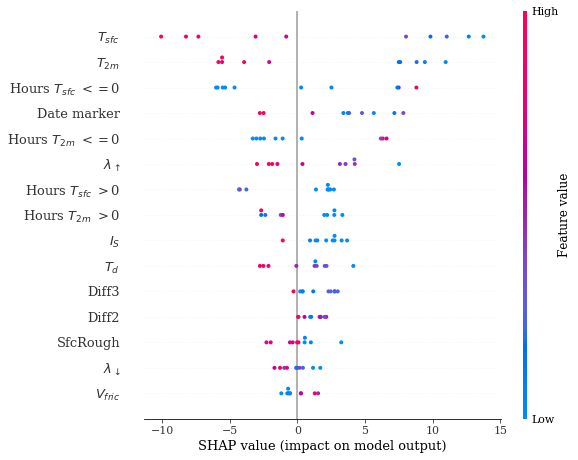

In [7]:
myInterpreter.plot_shap(
                    plot_type = 'summary',
                    shap_values=shap_values,
                    display_feature_names=plotting_config.display_feature_names,
                    to_probability=True)                           

### Dependence Plot

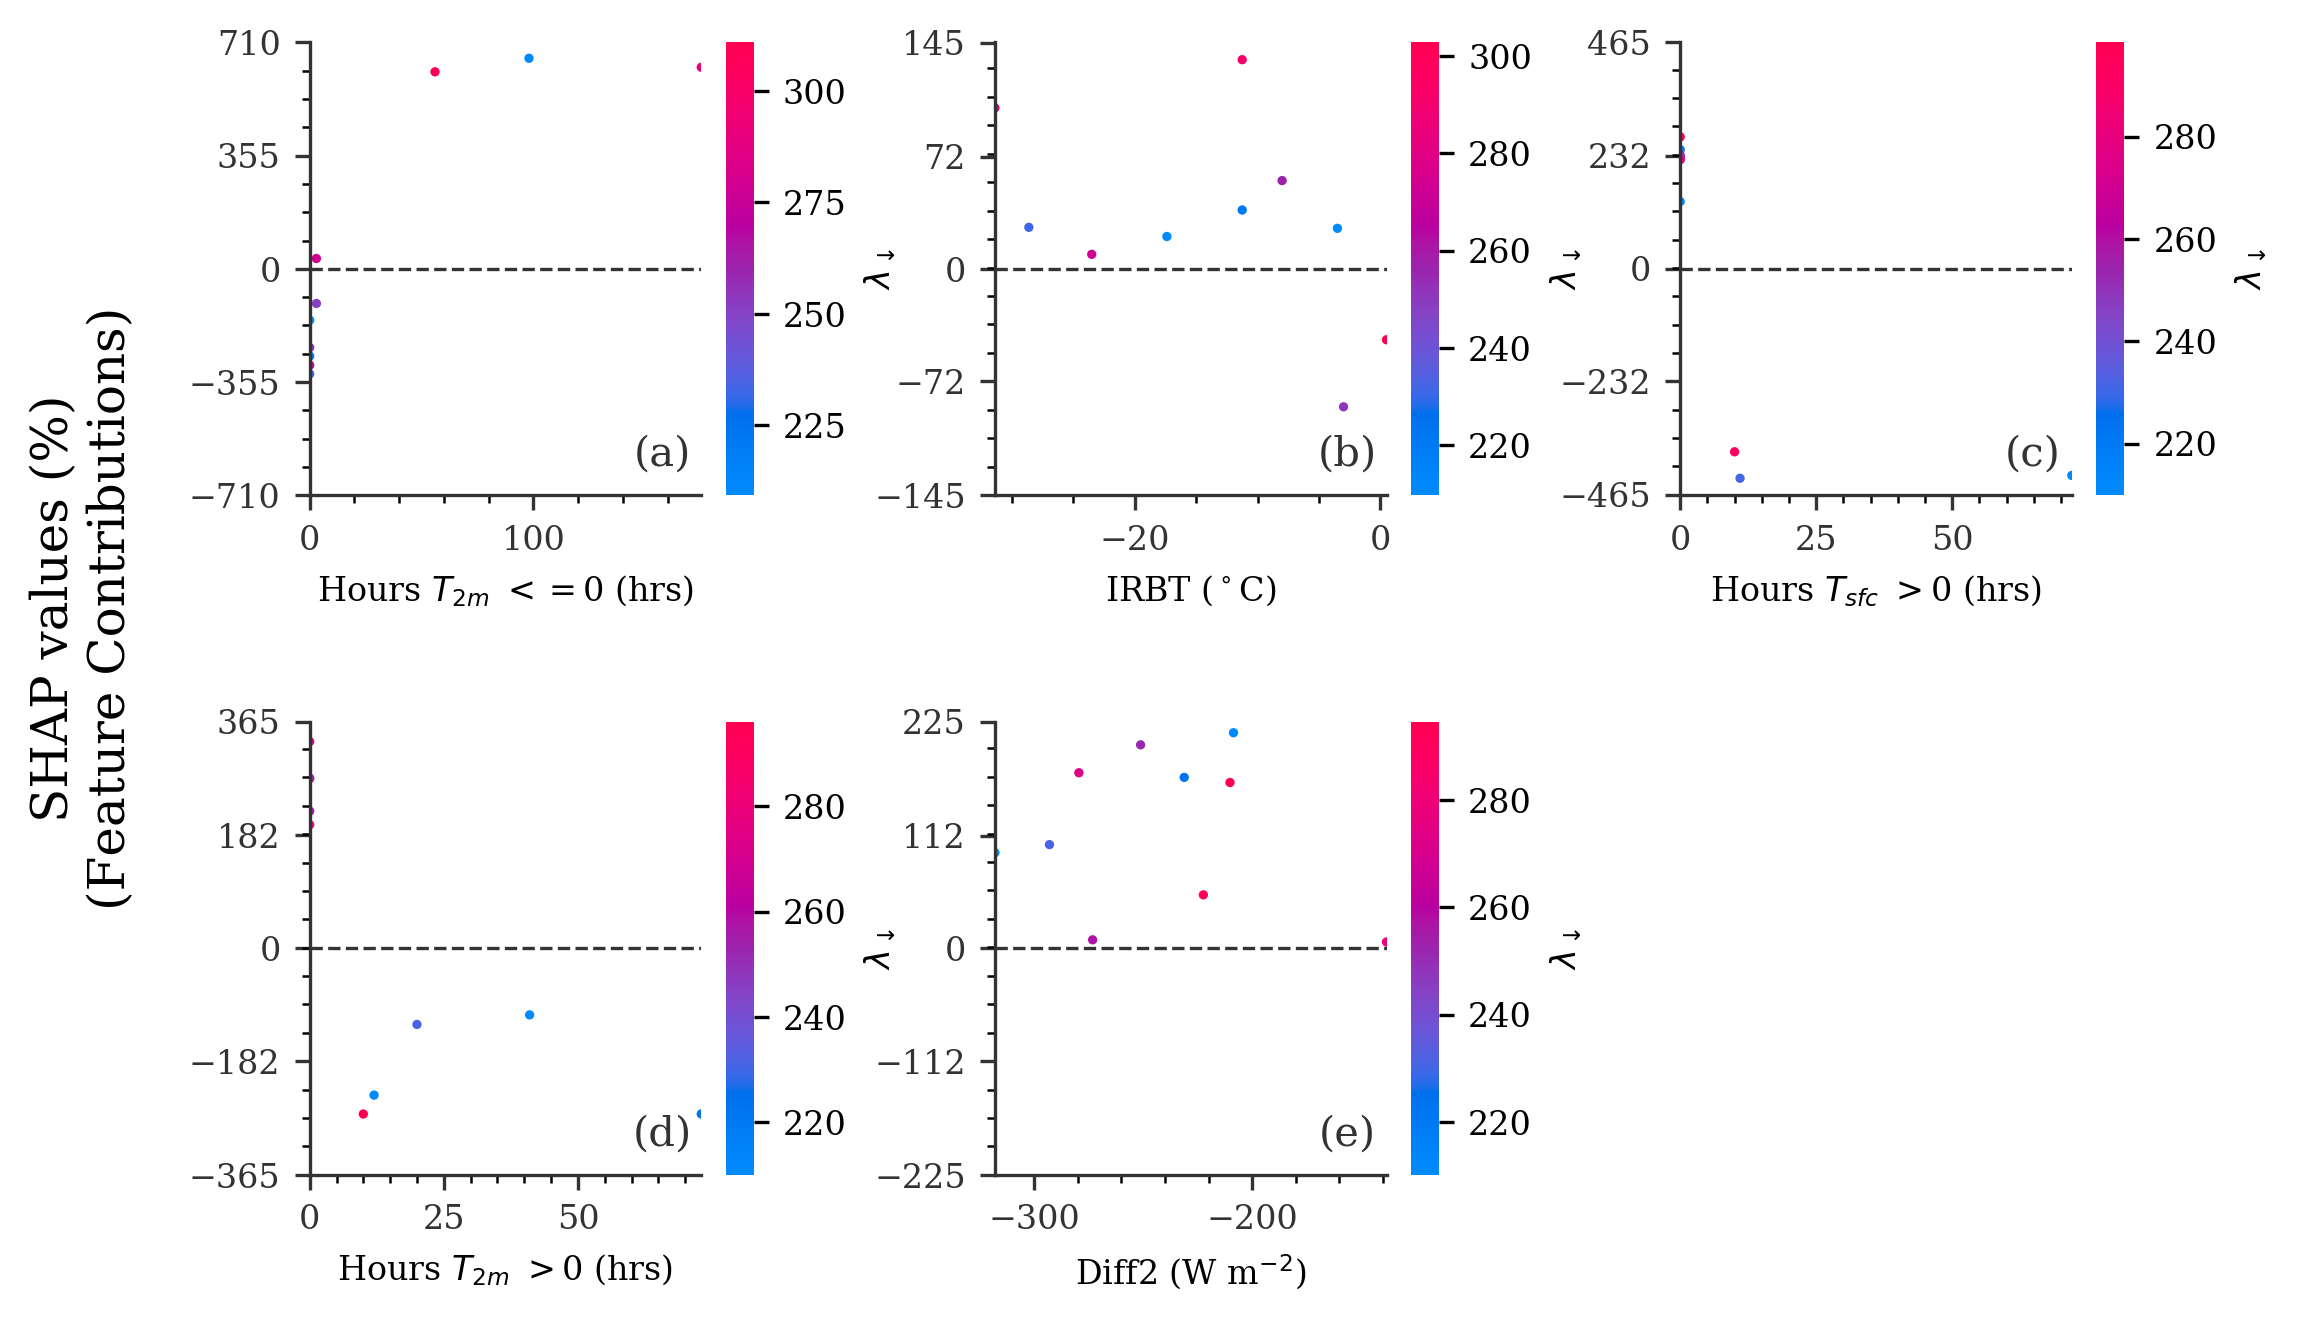

In [8]:
features = ['tmp2m_hrs_bl_frez', 'sat_irbt', 'sfcT_hrs_ab_frez', 'tmp2m_hrs_ab_frez', 'd_rad_d']
myInterpreter.plot_shap(features=features,
                        plot_type = 'dependence',
                        shap_values=shap_values,
                        display_feature_names=plotting_config.display_feature_names,
                        display_units = plotting_config.display_units,
                        to_probability=True)